This can be [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-3/blob/main/HW3_1_LanguageModelArchitectures.ipynb)
# Language model architectures, from RNNs to Transformers

In this notebook, you will get experience implementing the core logic within a few language model architectures, from RNNs to transformers.

## Preliminaries

Set up here.

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00


In [4]:
# First, we'll implement a simple RNN language model

import math
import random
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from ipywidgets import FloatSlider, interactive
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import time
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 2025
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Using device: cpu


## Dataset

We will create a **character-based** autoregressive language model, which means, it will predict one character at a time.

To train it, we will need a dataset class that provides character sequences, then we will load some text into it.

We use the TinyStories dataset.  ([Eldan, 2023](https://arxiv.org/abs/2305.07759))

In [4]:

# This class takes a string of text and a sequence length and
# breaks it down to character sequences of the given length.
class CharLMDataset(Dataset):
    def __init__(self, text, seq_length=20):
        self.seq_length = seq_length
        self.vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(self.vocab)}
        self.itos = {i: ch for i, ch in enumerate(self.vocab)}
        self.encoded_text = [self.stoi[ch] for ch in text]
        # Ensure we have enough tokens for both input and target sequences
        self.encoded_text = self.encoded_text[: len(self.encoded_text) - (len(self.encoded_text) % (seq_length + 1))]

    def __len__(self):
        # Number of complete chunks
        return len(self.encoded_text) // self.seq_length

    def __getitem__(self, idx):
        # Get the idx-th chunk
        chunk = self.encoded_text[idx * self.seq_length : (idx + 1) * self.seq_length + 1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y


# TinyStories (Eldan, 2023)[https://arxiv.org/abs/2305.07759] is a dataset of short, simple stories generated
# by GPT3.5 and GPT4. There about 2B characters in the full dataset, but we'll only use 10M
dataset_size = 10_000_000
batch_size = 32

tinystories = load_dataset("roneneldan/TinyStories")
full_text = "\n".join(tinystories["train"]["text"])[:dataset_size]
print(full_text[:1000])

dataset = CharLMDataset(full_text)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. B

# Recurrent Neural Networks

## Autoregressive Language Modeling

An autoregressive language model predicts the probability distribution of the next token given the previous tokens:

$$
P(x_t | x_{t-1}, x_{t-2}, ..., x_1) = g_\theta(x_{t-1}, x_{t-2}, ..., x_1)
$$

For the complete sequence, the joint probability factorizes as:

$$
P(x_1, ..., x_T) = \prod_{t=1}^T P(x_t | x_{t-1}, ..., x_1)
$$

Now, we need the neural network to plays the role of the abstract function $g_\theta$, which means that it must take a sequence of tokens as input, and produce a categorical distribution over possible next-tokens as output.  But every neural network has a fixed set of neurons.  How can we make one that takes an arbitrarily long sequence of inputs?

The idea of a **Recurrent Neural Network** is to implement the abstract $g_\theta$ as a Recurrent neural network $f_\theta$, that recursively consumes one token at a time.  The idea is to use a hidden state vector $h_t$ that summarizes the sequence history:

$$
g_\theta(x_{1:t}) = \text{softmax}(W_{out}f_\theta(x_t, f_\theta(x_{t-1}, f_\theta(x_{t-2}, ... f_\theta(x_1, h_0)...))) + b_{out})
$$

Each invocation of $f_\theta$ is now simple, consuming a single token and a single hidden state vector.

$
h_t = f_\theta(x_t, h_{t-1})
$


## Token Encoding

Some details: to get tokens into a neural network, we need to encode them as vectors.

Each input token $x_t$ is first mapped to a dense vector through an embedding layer:

$$
e_t = E x_t
$$

where $E \in \mathbb{R}^{d_{emb} \times |V|}$ is the embedding matrix and $|V|$ is the vocabulary size.

The model's hidden state $h_t$ captures the sequence context.

## Token Decoding

Then to get tokens out, we need to produce a distribution of output probabilities for the next token.

To predict the next token, we use a linear classifier that makes a prediction based on the hidden state:

$$
logits = W_{fc} h_t + b_{fc}
$$

$$
P(x_{t+1} | x_t, ..., x_1) = softmax(logits)
$$

where $W_{out} \in \mathbb{R}^{|V| \times d_{hidden}}$ projects the hidden state back to vocabulary-sized logits.

## Elman RNN Architecture

How do we get one hidden state from another?

The vanilla or Elman RNN arcthiecture is given by this rule:

$$
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh})
$$

where:
- $x_t$ is the input embedding at time $t$
- $h_t$ is the hidden state at time $t$
- $W_{ih} \in \mathbb{R}^{d_{hidden} \times d_{emb}}$ is the input-to-hidden weight matrix
- $W_{hh} \in \mathbb{R}^{d_{hidden} \times d_{hidden}}$ is the hidden-to-hidden weight matrix
- $b_{ih}, b_{hh} \in \mathbb{R}^{d_{hidden}}$ are the corresponding bias vectors

The hidden state $h_t$ serves as a memory that captures relevant information from previous tokens. The nonlinear $\tanh$ activation allows the network to learn complex temporal dependencies.

During generation, we:
1. Initialize $h_0$ to zeros
2. Sample each token from the predicted probability distribution
3. Update the hidden state using the sampled token
4. Repeat until reaching desired length

## SimpleRNN

In the implementation of an Elman below, each invocation produces both $h$ and $logits$.

**Exercise 1** Implement the code that implements the recurrent generation.

In [33]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # TODO: fill in the proper neural network dimensions
        self.W_ih = nn.Linear(embed_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()

    def forward(self, x_token, hidden=None):
        x_emb = self.embedding(x_token)
        # TODO: look at the Elman recurrence formula above and make the code match it.
        hidden = self.tanh(self.W_ih(x_emb) + self.W_hh(hidden))
        logits = self.fc(hidden)
        return logits, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=DEVICE)

    def generate_text(self, dataset, length=100):
        self.eval()
        # Start with a random token
        token = torch.randint(0, len(dataset.vocab), (1,), device=DEVICE)
        generated_tokens = [token.item()]
        hidden = self.init_hidden(1)

        # Generate one token at a time
        for _ in range(length-1):
            # Get predictions

            # YOUR CODE HERE
            # TODO:
            # 1. Call the neural network by adding the new token and re-feeding the hidden state
            logits, hidden = self.forward(token, hidden)
            # 2. Ensure the logits are converted to probability using softmax
            # print(logits)
            probs = torch.softmax(logits, dim=1)
            # 3. Choose the next token according to the model's predicted categorical probability distribution
            # HINT: torch.multinomial could be handy
            # print(probs)
            probs = probs.squeeze(0)
            token = torch.multinomial(probs, num_samples=1)

            generated_tokens.append(token.item())

        # Convert tokens back to text using the dataset's vocabulary
        generated_text = ''.join([dataset.itos[i] for i in generated_tokens])
        return generated_text

# Backpropagation Through Time

## The Chain Rule for RNNs

For a sequence of length T, the loss L depends on the model predictions at each timestep:

$$
L = \frac{1}{T}\sum_{t=1}^T L_t(y_t, \hat{y}_t)
$$

where $\hat{y}_t = \text{softmax}(W_{out}h_t + b_{out})$ and $h_t = f_\theta(x_t, h_{t-1})$.

The gradient with respect to parameters $\theta$ requires the chain rule through time:

$$
\frac{\partial L}{\partial \theta} = \frac{1}{T}\sum_{t=1}^T \frac{\partial L_t}{\partial \theta}
$$

For each timestep t, we must consider how $\theta$ affects the current prediction through all previous timesteps:

$$
\frac{\partial L_t}{\partial \theta} = \sum_{k=1}^t \frac{\partial L_t}{\partial h_t}\frac{\partial h_t}{\partial h_k}\frac{\partial h_k}{\partial \theta}
$$

## Implementation

The training code implements BPTT by:
1. Initializing hidden state $h_0$ for each sequence
2. Unrolling the RNN for T steps, accumulating loss at each step
3. Computing average loss over sequence length
4. Using autograd to compute gradients through the entire computational graph
5. Updating parameters with Adam optimizer

For each timestep t, the core computation is:

1. Forward pass through RNN:
   $\hat{y}_t = W_{out}h_t + b_{out}, \quad h_t = f_\theta(x_t, h_{t-1})$
   Remember that `model(x_batch[:, t], h_prev)` will calculate both of these.

3. Compute cross-entropy loss:
   $L_t = -\sum_k y_{t,k} \log(\text{softmax}(\hat{y}_t)_k)$.  In the code below, `criterion(logits, y_batch[:, t])` will calculate this.

   
5. Accumulate loss over sequence:
   $L = \frac{1}{T}\sum_{t=1}^T L_t$.  In the code below, remember to add up the loss for every token; we have included the `loss / seq_len` for you at the end.

The hidden state carries gradients backward through time, allowing the model to learn long-term dependencies.

(However, this can lead to vanishing/exploding gradients over long sequences.)

**Exercise 2:** Implement the missing code in the RNN training code below.

In [31]:
def train_language_model(model, dataloader, lr=1e-3, print_every=100, max_iters=None, is_rnn=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    losses = []

    start_time = time.time()
    for step, (x_batch, y_batch) in enumerate(dataloader):
        if max_iters is not None and step >= max_iters:
            break

        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        if is_rnn:
            # RNN/GRU: process sequence step by step
            h = model.init_hidden(x_batch.size(0))
            loss = 0

            # Unroll over seq_len
            for t in range(x_batch.size(1)):
                # YOUR CODE HERE
                # TODO:
                # 1. compute the logits for the next token and the next hidden state
                logits, h = model(x_batch[:, t], h)
                # 2. compute the loss for the probability distribution for the next token.
                loss_t = criterion(logits, y_batch[:, t])
                # 3. remember to accumulate the loss over all tokens.
                loss += loss_t
                # YOUR CODE HERE

            loss = loss / x_batch.size(1)
        else:
            # Transformer: process whole sequence at once
            logits, _ = model(x_batch)
            loss = criterion(logits.view(-1, logits.size(-1)), y_batch.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (step + 1) % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Step {step+1}, Loss: {loss.item():.4f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    return losses


def plot_losses(loss_dict):
    for description, losses in loss_dict.items():
        plt.plot(losses, label=description, alpha=0.7)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.show()


## Training loop below.

Experiment with the training loop below.  Your model should have no trouble getting to a cross-entropy loss of about 1.3 or 1.4.

Does the training produce a model with reasonable results?  If not, go back and debug!

Step 100, Loss: 2.2290, Time: 2.55s
Step 200, Loss: 1.9327, Time: 2.02s
Step 300, Loss: 1.8329, Time: 2.02s
Step 400, Loss: 1.6848, Time: 2.06s
Step 500, Loss: 1.6741, Time: 2.04s
Step 600, Loss: 1.7086, Time: 2.88s
Step 700, Loss: 1.6177, Time: 2.05s
Step 800, Loss: 1.5309, Time: 1.99s
Step 900, Loss: 1.5565, Time: 2.01s
Step 1000, Loss: 1.4927, Time: 2.05s
Step 1100, Loss: 1.5454, Time: 2.10s
Step 1200, Loss: 1.4332, Time: 2.82s
Step 1300, Loss: 1.5476, Time: 2.08s
Step 1400, Loss: 1.3632, Time: 2.05s
Step 1500, Loss: 1.3118, Time: 2.03s
Step 1600, Loss: 1.5518, Time: 2.05s
Step 1700, Loss: 1.3739, Time: 2.49s
Step 1800, Loss: 1.3559, Time: 2.46s
Step 1900, Loss: 1.4110, Time: 2.05s
Step 2000, Loss: 1.4338, Time: 2.04s


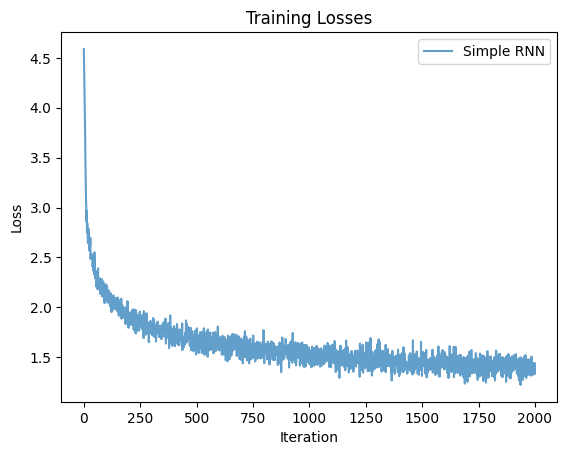


Sample text from Simple RNN: But day of the girl who likes yell and was rtone of pith a nead and rugged of his ice plents. They h
--------------------------------------------------------------------------------


In [34]:
hidden_size = 256
embed_size = 64
simple_rnn = SimpleRNN(len(dataset.vocab), embed_size, hidden_size).to(DEVICE)

simple_rnn_losses = train_language_model(simple_rnn, dataloader, max_iters=2000)
plot_losses({
    "Simple RNN": simple_rnn_losses,
})
# Generate some sample text from the RNN. After maybe 2000 iterations, you should be able to get a loss of 1.4, and see
# something that's recognizably English, but not perfect, with frequent misspellings.
sample_text = simple_rnn.generate_text(dataset)
print(f"\nSample text from Simple RNN: {sample_text}")
print("-" * 80)

# Extra Credit: Multi Layer RNN Architecture

## Basic Idea

In a multi-layer RNN, each layer processes the output of the previous layer. For layer l, the hidden state update is:

$$
h_t^{(l)} = f_\theta^{(l)}(h_t^{(l-1)}, h_{t-1}^{(l)})
$$

where $h_t^{(l)}$ is the hidden state at time t for layer l.

## Layer-wise Processing

The computation flows as follows:

1. Input embedding (layer 0):
$$h_t^{(0)} = Ex_t$$

2. First RNN layer:
$$h_t^{(1)} = \tanh(W_{ih}^{(1)}h_t^{(0)} + b_{ih}^{(1)} + W_{hh}^{(1)}h_{t-1}^{(1)} + b_{hh}^{(1)})$$

3. Subsequent layers (l > 1):
$$h_t^{(l)} = \tanh(W_{ih}^{(l)}h_t^{(l-1)} + b_{ih}^{(l)} + W_{hh}^{(l)}h_{t-1}^{(l)} + b_{hh}^{(l)})$$

4. Final output prediction:
$$\hat{y}_t = \text{softmax}(W_{out}h_t^{(L)} + b_{out})$$

where L is the total number of layers.

## Information Flow

The network now has two types of connections:
- Temporal connections (within each layer across time steps)
- Deep connections (between layers at each time step)

This allows the network to learn both:
- Temporal features (through recurrent connections)
- Hierarchical features (through layer stacking)


**EXTRA CREDIT**: Implement the MultiLayer RNN below, and then try training it and running it.

In [ ]:
class MultiLayerRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # TODO: Create ModuleLists for W_ih and W_hh
        # HINT: W_ih[0] should map from embed_size to hidden_size
        # subsequent W_ih[l] should map from hidden_size to hidden_size
        self.W_ih = nn.ModuleList([
            nn.Linear(embed_size, hidden_size),
        ] + [
            None # TODO - construct the needed module
            for i in range(num_layers - 1)
        ])

        self.W_hh = nn.ModuleList([
            # YOUR CODE HERE
            None # TODO - construct the needed module
            for i in range(num_layers)
        ])

        self.fc = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()

    def forward(self, x_token, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x_token.size(0))

        x = self.embedding(x_token)
        new_hidden = []

        for layer in range(self.num_layers):
            # Implement the recurrence for each layer
            layer_input = x if layer == 0 else new_hidden[-1]

            # YOUR CODE HERE: Apply the recurrence formula for this layer.
            # HINT: Use the formula from the markdown above
            # Compute h using self.W_ih[layer], self.W_hh[layer], and self.tanh,
            # (1) incorporating layer_input from layer stacking
            # (2) and the hidden[layer] from the temporal sequencing
            h = self.tanh(
                PROCESS_DATA_UP_THE_STACK +
                PROCESS_DATA_FROM_THE_SEQUENCE
            )

            new_hidden.append(h)

        logits = self.fc(new_hidden[-1])
        return logits, new_hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=DEVICE)
                for _ in range(self.num_layers)]

    def generate_text(self, dataset, length=100):
        self.eval()
        token = torch.randint(0, len(dataset.vocab), (1,), device=DEVICE)
        generated_tokens = [token.item()]
        hidden = self.init_hidden(1)

        for _ in range(length-1):
            logits, hidden = self(token, hidden)
            # TODO: Convert logits to probabilities and sample the next token
            # HINT: Use torch.multinomial after applying softmax
            probs = None  # YOUR CODE HERE
            token = None  # YOUR CODE HERE

            generated_tokens.append(token.item())

        generated_text = ''.join([dataset.itos[i] for i in generated_tokens])
        return generated_text

## (Extra Credit Continued) Multlayer training

(Extra credit): The training loop below can be use to test your multilayer model.  You will need to fill in the missing core loop.

In [ ]:
def train_multilayer_rnn(model, dataloader, lr=1e-3, print_every=100, max_iters=None):
    seq_len = dataloader.dataset.seq_length
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    losses = []
    start_time = time.time()

    for step, (x_batch, y_batch) in enumerate(dataloader):
        if max_iters is not None and step >= max_iters:
            break

        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        batch_size = x_batch.size(0)

        # Initialize hidden states for all layers
        h_prev = model.init_hidden(batch_size)
        loss = 0

        # Unroll over seq_len
        for t in range(seq_len):
            ## YOUR CODE HERE
            # This should all look quite similar to your previous training loop
            pass

        loss = loss / seq_len
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (step + 1) % print_every == 0:
            elapsed = time.time() - start_time
            print(f"(Multi-Layer RNN) Step {step+1}, Loss: {loss.item():.4f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    return losses

Extra credit, continued -

Experiment with different model sizes and other training configurations, and plot your findings.

In [ ]:
hidden_size = 256
embed_size = 64
num_layers = 2  # We can experiment with different numbers of layers

multilayer_rnn = MultiLayerRNN(
    vocab_size=len(dataset.vocab),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layers
).to(DEVICE)

multilayer_rnn_losses = train_multilayer_rnn(multilayer_rnn, dataloader, max_iters=2000)

# Plot both models for comparison
plot_losses({
    "Simple RNN": simple_rnn_losses,
    "Multi-Layer RNN": multilayer_rnn_losses,
})

# Generate sample text from the multilayer RNN
sample_text = multilayer_rnn.generate_text(dataset)
print(f"\nSample text from Multi-Layer RNN: {sample_text}")
print("-" * 80)

# Optional: Compare generations with different numbers of layers
for layers in [2, 3, 4]:
    model = MultiLayerRNN(
        vocab_size=len(dataset.vocab),
        embed_size=embed_size,
        hidden_size=hidden_size,
        num_layers=layers
    ).to(DEVICE)
    losses = train_multilayer_rnn(model, dataloader, max_iters=2000)
    print(f"\nSample text from {layers}-layer RNN:")
    print(model.generate_text(dataset))
    print("-" * 80)

This is the end of the extra-credit section.  Back to the required part of the homework.

# Computational Efficiency of the Classic RNN

Let's analyze the efficiency of the RNN. For an Elman RNN with:
- Hidden dimension D
- Vocabulary size V
- Sequence length T
- Number of layers L

For this exercise, you can assume that the embedding dimension is the same as the hidden dimension D.

1. How many FLOPs are needed to generate T tokens? (In this, and all the questions in this HW, you can ignore small calculations like biases and assume that there's a single batch. You can also assume that an AxB matrix and a BxC matrix take 2ABC FLOPs to be multiplied together (about half of those are scalar multiplications and half are scalar additions). Don't worry about the final projection to the vocabulary dimension.  Even though we implemented a single layer, in the general case the model could implement L layers per step.)

> YOUR ANSWER: To process a single token and a single layer we require 2 matrix multiplications with dimension D x D, which comes to $4D^2$ FLOPS per token.  Doing it for L layers and T tokens requires a total of $4D^2LT$ FLOPs.

2. How many FLOPs are needed to train on a sequence of T tokens?  (Not counting training the classifier layer $W_{ff}$.)

> YOUR ANSWER: For each layer and for a single token, we need to calculate the gradients with respect to $W_{ih}$ and $W_{hh}$. Each of these is a D by D matrix multiplication which comes to $4D^2$  FLOPS.  We also need to propagate the gradients with respect to the input (to train the embedding), which adds $2D^2$ FLOPS for a single token, and and hidden states (to backpropgate through time) which is $4D^2$ FLOPS per token.   So for each layer and for a single token, we need $8D^2$ FLOPS.  We do this for L layers and T tokens, so the total is $8LTD^2$ FLOPs.

3. Counting FLOPS can overestimate how expensive neural networks are on a GPU, which can parallelize the operations in a matrix (or matrix-vector) operation very efficiently. Since a modern GPU can process a fairly good-sized matrix multiplication in a small amount of real-world wall-clock time, it can be more informative to count these matrix multiplications.  How many sequential matrix multiplications are needed to generate T tokens?

> YOUR ANSWER: For each layer and for a single token, we need 3 matrix multiplications, So over all L layers and T tokens we need $3LT$ sequential matrix multiplications.

4. How many sequential matrix multiplications are needed to train on T tokens?

> YOUR ANSWER: For each layer and for a single token, we need 6 matrix multiplications, So over all L layers and T tokens we need $6LT$ sequential matrix multiplications.

# The GRU Cell

Can we improve on the RNN? We can try a GRU, or Gated Recurrent Unit (Cho et al., 2014)[https://arxiv.org/abs/1406.1078].

A Gated Recurrent Unit (GRU) is a gating mechanism for RNNs that helps control information flow. Let's understand its components:

## Gate Mechanisms

The GRU has two gates and a memory update mechanism:

1. **Reset Gate** ($r_t$):
   $$r_t = \sigma(W_{xr}x_t + W_{hr}h_{t-1})$$
   Controls how much of the previous hidden state to use in forming the new memory content.

2. **Update Gate** ($z_t$):
   $$z_t = \sigma(W_{xz}x_t + W_{hz}h_{t-1})$$
   Controls how much of the previous hidden state to keep vs. how much to update.

3. **New Content** ($n_t$):
   $$n_t = \tanh(W_{xn}x_t + r_t \odot (W_{hn}h_{t-1}))$$
   Proposes new content based on input and gated previous state.

4. **Final Update** ($h_t$):
    The hidden state is updated as:
    $$h_t = (1-z_t) \odot n_t + z_t \odot h_{t-1}$$

In the above:
- $\sigma$ is the sigmoid function
- $\odot$ represents element-wise multiplication
- $W_*$ are learnable weight matrices
- $x_t$ is the input at time $t$
- $h_{t-1}$ is the previous hidden state


This allows the GRU to:
- Learn long-term dependencies (through the update gate)
- Adaptively reset its state (through the reset gate)
- Propose relevant new content (through the memory content)


## GRUCell code
Here is how the code looks:

In [5]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Reset gate parameters
        self.W_xr = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hr = nn.Linear(hidden_size, hidden_size, bias=False)

        # Update gate parameters
        self.W_xz = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hz = nn.Linear(hidden_size, hidden_size, bias=False)

        # New content parameters
        self.W_xn = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hn = nn.Linear(hidden_size, hidden_size, bias=False)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        # Compute reset gate
        r_t = self.sigmoid(self.W_xr(x) + self.W_hr(hidden))

        # Compute update gate
        z_t = self.sigmoid(self.W_xz(x) + self.W_hz(hidden))

        # Compute new memory content
        n_t = self.tanh(self.W_xn(x) + r_t * self.W_hn(hidden))

        # Update hidden state
        h_t = (1 - z_t) * n_t + z_t * hidden

        return h_t, r_t, z_t, n_t

In [8]:
def plot_gru_2d_step(data_input=0.0, control_input=0.0,
                     data_hidden=0.0, control_hidden=0.0,
                     reset_weight=0.0, update_weight=0.0,
                     new_input_weight=3.0, new_hidden_weight=0.0):

    gru = GRUCell(input_size=2, hidden_size=2)

    # Set specific weights for control and data flow
    with torch.no_grad():
        # Zero out all weights first
        gru.W_xr.weight.zero_()
        gru.W_hr.weight.zero_()
        gru.W_xz.weight.zero_()
        gru.W_hz.weight.zero_()
        gru.W_xn.weight.zero_()
        gru.W_hn.weight.zero_()

        # Gates controlled by control dimension but affecting data dimension
        gru.W_xr.weight[0, 1] = reset_weight  # Reset gate
        gru.W_hr.weight[0, 1] = reset_weight

        gru.W_xz.weight[0, 1] = update_weight  # Update gate
        gru.W_hz.weight[0, 1] = update_weight

        # New memory weights for data dimension
        gru.W_xn.weight[0, 0] = new_input_weight   # From input
        gru.W_hn.weight[0, 0] = new_hidden_weight  # From hidden state

    # Create input and hidden tensors
    x = torch.tensor([[data_input, control_input]], dtype=torch.float32)
    h = torch.tensor([[data_hidden, control_hidden]], dtype=torch.float32)

    # Get GRU outputs
    with torch.no_grad():
        new_h, r, z, n = gru(x, h)

    # Create figure focusing only on data dimension
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot all relevant data dimension values
    labels = ['x[0]\nInput', 'h[0]\nPrev Hidden', 'r[0]\nReset Gate', 'z[0]\nUpdate Gate',
              'n[0]\nNew Content', 'h_new[0]\nFinal Output']
    values = [x[0,0].item(), h[0,0].item(), r[0,0].item(), z[0,0].item(),
              n[0,0].item(), new_h[0,0].item()]
    colors = ['blue', 'gray', 'lightblue', 'lightgreen', 'orange', 'red']

    # Create bars without labels on x-axis
    bars = ax.bar(range(len(values)), values, color=colors)
    ax.set_ylim(-2, 2)
    ax.set_title('GRU Data Flow (Data Dimension)')

    # Remove x-axis ticks
    ax.set_xticks([])

    # Add labels inside the plot
    for idx, (bar, label, value) in enumerate(zip(bars, labels, values)):
        # Position labels near the top of the plot
        y_pos = 1.8  # Position at top of plot

        # Add the label
        ax.text(idx, y_pos, label, ha='center', va='top')

        # Add the value on top if bar is positive, below if negative
        value_pos = 0.1 if value < 0 else -0.1
        ax.text(idx, value + value_pos, f'{value:.2f}',
                ha='center', va='bottom' if value < 0 else 'top')

    plt.tight_layout()
    plt.show()

# Create sliders with wider labels and organized in two columns
from ipywidgets import HBox, VBox

# Input sliders
data_input_slider = FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1, readout_format='.1f',
    description='Input x[0] (Data):', style={'description_width': '140px'})
control_input_slider = FloatSlider(
    value=3.0, min=-2.0, max=2.0, step=0.1, readout_format='.1f',
    description='Input x[1] (Control):', style={'description_width': '140px'})
data_hidden_slider = FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1, readout_format='.1f',
    description='Hidden x[0] (Data):', style={'description_width': '140px'})
control_hidden_slider = FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1, readout_format='.1f',
    description='Hidden x[1] (Control):', style={'description_width': '140px'})

# Weight sliders
reset_weight_slider = FloatSlider(
    value=3.0, min=-3.0, max=3.0, step=0.2, readout_format='.1f',
    description='Reset W_xr W_hr[0,1]:', style={'description_width': '160px'})
update_weight_slider = FloatSlider(
    value=-3.0, min=-3.0, max=3.0, step=0.2, readout_format='.1f',
    description='Update W_xz W_hz[0,1]:', style={'description_width': '160px'})
new_input_weight_slider = FloatSlider(
    value=3.0, min=-3.0, max=3.0, step=0.2, readout_format='.1f',
    description='New Content W_xn[0,0]:', style={'description_width': '160px'})
new_hidden_weight_slider = FloatSlider(
    value=3.0, min=-3.0, max=3.0, step=0.2, readout_format='.1f',
    description='New Content W_hn[0,0]:', style={'description_width': '160px'})

# Arrange sliders in four columns
col_1 = VBox([data_input_slider, control_input_slider])
col_2 = VBox([data_hidden_slider, control_hidden_slider])
col_3 = VBox([reset_weight_slider, update_weight_slider])
col_4 = VBox([new_input_weight_slider, new_hidden_weight_slider])

slider_layout = HBox([col_1, col_2, col_3, col_4])

interactive_plot = interactive(
    plot_gru_2d_step,
    data_input=data_input_slider,
    control_input=control_input_slider,
    data_hidden=data_hidden_slider,
    control_hidden=control_hidden_slider,
    reset_weight=reset_weight_slider,
    update_weight=update_weight_slider,
    new_input_weight=new_input_weight_slider,
    new_hidden_weight=new_hidden_weight_slider
)

# Display both the sliders and the plot
VBox([slider_layout, interactive_plot.children[-1]])

# Understanding GRU Behavior By Interactive Experiments

The GRU demonstration above is set up to show how a GRU can selectively update, preserve, or modify information.

We have used a simplified two-dimenstional hidden state space.

The way we have set up the weight matrices, the data dimension (index 0) carries the actual values we want to process, while the control dimension (index 1) determines how the gates behave.  For the first exercises, we will leave the Input x[1] (Control) to be a high value, 2.0. Then you will experiment with altering the weights, to see how they affect the relationship between inputs and outputs.

## Exercise 1: Understanding Default Behavior

The default settings (New Content Weights = 3.0) are configured to make the hidden state contain an attenuated sum of the input and the previous hidden state.

**Questions:**
1. Move the "Input x[0] (Data)" slider. Does the (a) new content and (b) final output wiggle in the same direction, opposite direction, or not at all?
> YOUR ANSWER: When the input varies, the new content wiggles high/low  The final output wiggles high/low - they wiggle in the same direction
2. Move the "Hidden x[0] (Data)" slider. Does the new content and final output respond similarly?
> YOUR ANSWER: When the hidden state varies, the new content wiggles high/low  The final output wiggles high/low
3. Set both input and hidden state data values high (e.g., 2.0). What happens to the output - is it high, low, or zero?
> YOUR ANSWER: When both input and hidden state are high, the new content is high  The final output is high  Due to the attenuation, the maximum range of the new content is 1.00


## Exercise 2: Computing Differences

**Task:** Modify the "New Content" weights (W_xn[0,0] and W_hn[0,0]) to make the GRU compute the attenuated difference between input and hidden state, rather than their sum.

**Success Criteria:**
- The new content should wiggle in the opposite direction of the hidden state
- When both input and hidden state data are high, the new content should be close to zero
- The final output should reflect this difference computation

**Question:** What weights did you use to achieve this?
4. Set both input and hidden state data values high (e.g., 2.0). What happens to the output - is it high, low, or zero?
> YOUR ANSWER: To compute differences, set the weights to 0.8 and -0.8, when both input and hidden state are high the output is closer to zero.


## Exercise 3: Perfect Memory

**Task:** Find settings of the weights that cause the GRU to (almost) completely ignore the new content and instead copy the old hidden state to the new hidden state.

**Questions:**
1. What weight settings achieve this?
> YOUR ANSWER: For perfect memory, use the weight settings - update gate to max.
2. Which gate is primarily responsible for this behavior?
> YOUR ANSWER: Update gate
3. How do you know that this setting is ignoring the new content and using just copying old hidden state?
> YOUR ANSWER: The old hidden value is exactly same for new hidden value (Output) at all positions of the slider.

## Exercise 4: Pure Input Mode

**Task:** Find settings of the weights that make the GRU (almost) completely ignore the old hidden state and only use the new input, when computing the new content.

**Questions:**
1. What weight settings achieve this?
> YOUR ANSWER: To ignore the old hidden state, use the weight settings (Reset gate to lowest)
2. Which gate is primarily responsible for this behavior?
> YOUR ANSWER: Reset Gate
3. How can you verify your solution is correct?
> YOUR ANSWER: Changing old hidden state has no effect on the final new content

## Final Observation: Control Channel

For all the above experiments, we kept the "Input [Control]" value high at 2.0.

**Task:** For each of the previous configurations you found, try setting the control input to 0.0 instead of 2.0.

**Questions:**
1. What happens to the gating behavior?
> YOUR ANSWER: The reset gate allows more influence from hidden state and vice versa update gate allows more influence from input gate.
2. Why is this control channel important for the GRU's operation?
> YOUR ANSWER: It allows for dynamic adaptation of past memory, which means that with the control gate you can control how much of the information is retained or ignored.
3. In a practical application, what might this control channel represent?
> YOUR ANSWER: Allows for how much of the past is important (eg. time series data) and how much weightage should be given. An example is finding anomalies in heart rate by comparing past heart rate and current.


# Training an RNN using a GRU cell

Let's try the GRU on real data. We'll keep the same hyperparameters as the previous RNN model.

**Exercise**: Modify the code below to incorporate the GRUCell, and fill in the standard autoregressive generation loop.  Then train the model and compare it to the RNN.

Compare the behavior of the GRU RNN with the vanilla Elman RNN.

> YOUR FINDINGS: Compared to the Elman RNN, the GRU RNN....

In [42]:
class GRULM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru_cell = GRUCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        hidden_out, _, _, _ = self.gru_cell(x, hidden)
        return self.fc(hidden_out), hidden_out

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=DEVICE)

    def generate_text(self, dataset, length=100):
        self.eval()
        # Start with a random token
        token = torch.randint(0, len(dataset.vocab), (1,), device=DEVICE)
        generated_tokens = [token.item()]
        hidden = self.init_hidden(1)

        # Generate one token at a time
        for _ in range(length-1):
            logits, hidden = self.forward(token, hidden)
            probs = torch.softmax(logits, dim=1)
            probs = probs.squeeze(0)
            token = torch.multinomial(probs, num_samples=1)
            generated_tokens.append(token.item())

        # Convert tokens back to text using the dataset's vocabulary
        generated_text = ''.join([dataset.itos[i] for i in generated_tokens])
        return generated_text

Run the training code below; the GRU RNN should perform well - if it doesn't, try debugging your code!

Step 100, Loss: 2.1370, Time: 5.59s
Step 200, Loss: 1.8432, Time: 4.41s
Step 300, Loss: 1.7691, Time: 5.32s
Step 400, Loss: 1.7004, Time: 4.35s
Step 500, Loss: 1.6173, Time: 4.36s
Step 600, Loss: 1.6335, Time: 5.26s
Step 700, Loss: 1.4479, Time: 4.37s
Step 800, Loss: 1.4298, Time: 5.19s
Step 900, Loss: 1.4908, Time: 4.46s
Step 1000, Loss: 1.4533, Time: 4.43s
Step 1100, Loss: 1.3745, Time: 6.19s
Step 1200, Loss: 1.4200, Time: 4.36s
Step 1300, Loss: 1.4476, Time: 5.03s
Step 1400, Loss: 1.3873, Time: 4.66s
Step 1500, Loss: 1.3876, Time: 4.32s
Step 1600, Loss: 1.2826, Time: 5.33s
Step 1700, Loss: 1.2919, Time: 4.32s
Step 1800, Loss: 1.2724, Time: 4.32s
Step 1900, Loss: 1.3211, Time: 5.24s
Step 2000, Loss: 1.3293, Time: 4.38s

Sample text from GRU:
â€“, it their tries and them inside.
Once upon a time build the could of very happy bader long tpett
--------------------------------------------------------------------------------


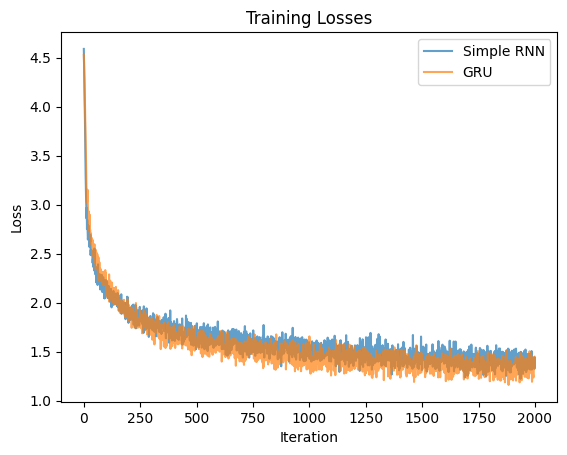

In [43]:
# Set up model with same hyperparameters as RNN
hidden_size = 256
embed_size = 64
gru_model = GRULM(len(dataset.vocab), embed_size, hidden_size).to(DEVICE)

# Use the same training function as before
gru_losses = train_language_model(gru_model, dataloader, max_iters=2000)

# Generate sample text from models and compare
print("\nSample text from GRU:")
sample_text = gru_model.generate_text(dataset)
print(sample_text)
print("-" * 80)

# Plot losses to compare models
plot_losses({
    "Simple RNN": simple_rnn_losses,
    "GRU": gru_losses,
})

Your loss curves should look pretty similar. What's going on? Whether the GRU is better or worse than an RNN can
depend on many factors, including the dataset, the model architectures, and the hyperparameters. One especially common
story about GRUs is that they're better at capturing long-term dependencies than RNNs. Let's see if that's true, by
bumping up the sequence length.

Step 100, Loss: 1.9937, Time: 10.33s
Step 200, Loss: 1.7557, Time: 10.18s
Step 300, Loss: 1.6031, Time: 10.22s
Step 400, Loss: 1.5228, Time: 9.40s
Step 500, Loss: 1.4827, Time: 9.99s
Step 600, Loss: 1.3900, Time: 10.21s
Step 700, Loss: 1.4077, Time: 10.15s
Step 800, Loss: 1.3313, Time: 10.12s
Step 900, Loss: 1.3356, Time: 9.28s
Step 1000, Loss: 1.3267, Time: 10.10s
Step 1100, Loss: 1.2181, Time: 10.09s
Step 1200, Loss: 1.2684, Time: 10.16s
Step 1300, Loss: 1.2932, Time: 10.29s
Step 1400, Loss: 1.2436, Time: 9.47s
Step 1500, Loss: 1.1937, Time: 9.93s
Step 1600, Loss: 1.2118, Time: 10.12s
Step 1700, Loss: 1.1432, Time: 10.20s
Step 1800, Loss: 1.1408, Time: 10.11s
Step 1900, Loss: 1.1339, Time: 9.50s
Step 2000, Loss: 1.1948, Time: 9.95s
Step 2100, Loss: 1.1773, Time: 10.14s
Step 2200, Loss: 1.1949, Time: 10.22s
Step 2300, Loss: 1.1704, Time: 10.20s
Step 2400, Loss: 1.1866, Time: 9.33s
Step 2500, Loss: 1.1226, Time: 9.87s
Step 2600, Loss: 1.0909, Time: 10.18s
Step 2700, Loss: 1.1174, Time:

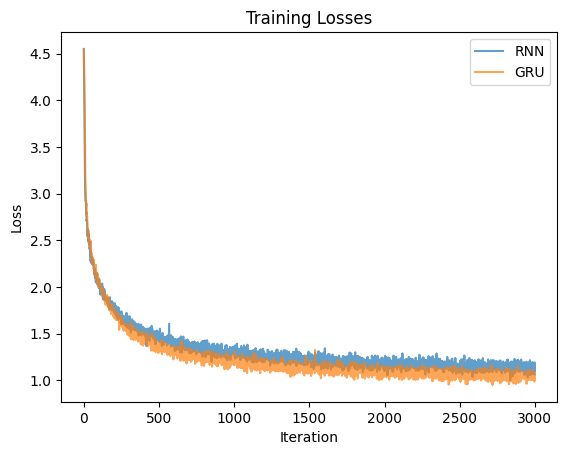

In [44]:
max_iters = 3_000

dataset = CharLMDataset(full_text, seq_length=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Train RNN
simple_rnn = SimpleRNN(len(dataset.vocab), embed_size, hidden_size).to(DEVICE)
rnn_losses = train_language_model(simple_rnn, dataloader, max_iters=max_iters)

sample_text = simple_rnn.generate_text(dataset)
print(f"\nSample text from RNN: {sample_text}")
print("-" * 80)

# Train GRU using same architecture and training function
simple_gru = GRULM(
    vocab_size=len(dataset.vocab),
    embed_size=embed_size,
    hidden_size=hidden_size
).to(DEVICE)
gru_losses = train_language_model(simple_gru, dataloader, max_iters=max_iters)

sample_text = simple_gru.generate_text(dataset)
print(f"\nSample text from GRU: {sample_text}")
print("-" * 80)

# Plot loss curves
plot_losses({
    "RNN": rnn_losses,
    "GRU": gru_losses,
})

# Transformer LM

Can we do even better? The Transformer (Vaswani et al., 2017)[https://arxiv.org/abs/1706.03762] seems like a good
candidate. We'll adapt Andrej Karpathy's nanoGPT (https://github.com/karpathy/nanoGPT), itself based on GPT2, to our
setting. nanoGPT uses a pre-LayerNorm architecture, GeLU activations, and simple learned positional encodings.

For another take on implementing a transformer, see the ARENA materials at https://arena-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch

Here is an implementation guide for the transformer below.

## 1. Main Forward Pass (Transformer class)

The forward pass combines token and positional embeddings, then processes them through transformer blocks:

**Mathematical formulation:**
1. Token embeddings: $E_{tok} = \text{Embedding}(idx) \in \mathbb{R}^{b \times t \times d}$
2. Position embeddings: $E_{pos} = \text{Embedding}(\text{range}(t)) \in \mathbb{R}^{t \times d}$
3. Combined: $x = E_{tok} + E_{pos}$

**Implementation:**
```python
# Get token embeddings
tok_emb = self.transformer.token_embedding(idx)  # shape: (b, t, n_embd)

# Get position embeddings
pos_emb = self.transformer.position_embedding(pos)  # shape: (t, n_embd)

# Combine embeddings
x = tok_emb + pos_emb

# Process through transformer blocks
for block in self.transformer.blocks:
    x = block(x)

# Final layer norm
x = self.transformer.ln_f(x)
```

## 2. Block Forward Pass

Each transformer block applies attention and MLP with residual connections:

**Mathematical formulation:**
1. Attention: $x = x + \text{Attention}(\text{LayerNorm}(x))$
2. MLP: $x = x + \text{MLP}(\text{LayerNorm}(x))$

**Implementation:**
```python
# Attention with residual connection
x = x + self.attn(self.ln_1(x))

# MLP with residual connection
x = x + self.mlp(self.ln_2(x))
```

## 3. Attention Implementation

The self-attention mechanism computes weighted combinations of values based on query-key similarity:

**Mathematical formulation:**
1. Project to Q/K/V: $Q, K, V = WX$ where $W \in \mathbb{R}^{3d \times d}$
2. Attention scores: $A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + \text{mask}\right)$
3. Output: $y = AV$

**Implementation:**
```python
# Manual implementation of attention (non-flash version)
# Scale dot product of Q and K
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

# Apply causal mask (sets future positions to -inf before softmax)
att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))

# Apply softmax to get attention weights
att = F.softmax(att, dim=-1)

# Multiply by values
y = att @ v  # shape: (B, nh, T, hs)

# Reshape back: combine all heads
y = y.transpose(1, 2).contiguous().view(B, T, C)
```

## 4. Text Generation

For generating text, we:
1. Start with a sequence containing one random token
2. Repeatedly:
   - Get model predictions
   - Sample next token from the predicted distribution
   - Append to sequence

**Implementation:**
```python
# Model is in eval mode
self.eval()

# Start with a random token
x = torch.randint(0, len(dataset.vocab), (1, 1), device=DEVICE)

for _ in range(max_new_tokens):
    # Get model predictions
    logits, _ = self(x)
    
    # Get probabilities for next token
    logits = logits[:, -1, :]
    probs = F.softmax(logits, dim=-1)
    
    # Sample next token
    x_next = torch.multinomial(probs, num_samples=1)
    
    # Append to sequence
    x = torch.cat((x, x_next), dim=1)

# Convert to text
text = "".join([dataset.itos[i.item()] for i in x[0]])
```

## Implementation Tips

1. **Shape checking**: The most common issues arise from incorrect tensor shapes. Key shapes:
   - Input idx: (batch_size, seq_len)
   - Embeddings: (batch_size, seq_len, n_embd)
   - Attention: (batch_size, n_heads, seq_len, head_size)

2. **Causal masking**: The causal mask ensures tokens can only attend to previous positions:
   ```python
   # Mask shape: (1, 1, seq_len, seq_len)
   mask = torch.tril(torch.ones(block_size, block_size))
   ```

3. **Multi-head attention**: Remember to:
   - Split attention heads: `view(B, T, n_head, head_size)`
   - Transpose for matrix multiplication: `transpose(1, 2)`
   - Combine heads at end: `view(B, T, n_embd)`

In [49]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.transformer = nn.ModuleDict(
            dict(
                token_embedding=nn.Embedding(config.vocab_size, config.n_embd),
                position_embedding=nn.Embedding(config.block_size, config.n_embd),
                blocks=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.n_embd, bias=False),
            )
        )
        self.config = config
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.token_embedding.weight = self.lm_head.weight  # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # forward the GPT model itself
        # TODO: implement the transformer forward-pass.  As a guide, see the Main Forward Pass above.
        # YOUR CODE HERE
        tok_emb = self.transformer.token_embedding(idx)
        pos_emb = self.transformer.position_embedding(pos)
        x = tok_emb + pos_emb
        for block in self.transformer.blocks:
          x = block(x)
        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        # return tuple to mimic RNNs trained previously
        return logits, None

    @torch.no_grad()
    def generate_text(self, dataset, max_new_tokens=100):
        self.eval()
        # Start with a random token
        x = torch.randint(0, len(dataset.vocab), (1, 1), device=DEVICE)
        # TODO: add the standard autoregressive text generation loop here,
        # as adapted to the transformer.
        # HINT: consult 4. Text Generation above.
        for _ in range(max_new_tokens):
          logits, _ = self(x)
          logits = logits[:, -1, :]
          probs = torch.softmax(logits, dim=-1)
          token = torch.multinomial(probs, num_samples=1)
          x = torch.cat((x, token), dim=1)

        # probs = probs.squeeze(0)


        text = "".join([dataset.itos[i.item()] for i in x[0]])

        return text


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, bias=False)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, bias=False)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)
        self.config = config
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.config.n_embd, dim=2)
        k = k.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.config.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0, is_causal=True)
        else:
            # manual implementation of attention
            # TODO: implement attention.
            # 1. Use k and q to compute the all-pairs attention weighting
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            # 2. Modify the attention weighting for autoregressive "causal" visibility
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf")) # YOUR CODE HERE
            # 3. Apply softmax
            att = F.softmax(att, dim=-1)
            # 4. Use attention to gather and distribute the v data
            y = att @ v # YOUR CODE HERE
            # 5. Reshape the data to re-assemble all head outputs for the hidden state
        y = y.transpose(1, 2).contiguous().view(B, T, C) # YOUR CODE HERE

        # output projection
        y = self.c_proj(y)

        return y


@dataclass
class TransformerConfig:
    vocab_size: int = len(dataset.vocab)
    # Here, we're choosing an embedding size to roughly match the GRUs parameters
    n_embd: int = 128
    block_size: int = 100
    n_layer: int = 1
    n_head: int = 4
    flash: bool = True


# Check that your attention implementation is correct by comparing your CausalSelfAttention to the PyTorch implementation
flash_transformer = Transformer(TransformerConfig(flash=True))
naive_transformer = Transformer(TransformerConfig(flash=False))

# Match weights between the two models
naive_transformer.load_state_dict(flash_transformer.state_dict())

random_input = torch.randint(0, len(dataset.vocab), (2, 8))
flash_output, _ = flash_transformer.forward(random_input)
naive_output, _ = naive_transformer.forward(random_input)

assert torch.allclose(flash_output, naive_output, atol=1e-6), f"differences: {flash_output - naive_output}"

Now let's analyze the efficiency of our Transformer.  With:
- Model dimension D
- Number of heads H
- Head dimension J = D/H
- Sequence length T
- Number of layers L

1. How many FLOPs are needed to generate T tokens? (You can ignore small calculations like biases and assume that there's a single batch. You can also assume that an AxB matrix and a BxC matrix take 2ABC FLOPs to be multiplied together. Don't worry about the final projection to the vocabulary dimension, or about LayerNorm.)

> YOUR ANSWER: For a single layer, the MLP is: $16TD^2$  FLOPs.

> YOUR ANSWER: For a single layer, computing the K, Q, and V togther is: $6TDJ$  FLOPs for each head and $6TD^2$ FLOPS for all heads together.

> YOUR ANSWER: For a single layer, computing the attention matrix is: $2T^2J$  FLOPs for each head and $2T^2D $ FLOPS for all heads together.

> YOUR ANSWER: For a single layer, processing all the values through attention is: $2T^2J$  FLOPs for each head and $2T^2D$ FLOPS for all heads together.

> YOUR ANSWER: After concatentating all head results, the final projection is $2T^2D$ FLOPS

> YOUR ANSWER: Therefore the total flops for a single layer of attention is $24TD^2 + 4T^2D$ FLOPS

> YOUR ANSWER: Adding up all layers the cost to generate T tokens is $L(24TD^2 + 4T^2D)$ FLOPS


2. How many FLOPs are needed to train on a sequence of T tokens?

> YOUR ANSWER: A single forward pass requires $L(24TD^2 + 4T^2D)$ FLOPS and the backward pass requires $L(48TD^2 + 8T^2D) FLOPS.

3. How many sequential matrix multiplications are needed to generate T tokens?

> YOUR ANSWER: For a single layer the MLP requires 2 sequential matrix multiplications.

> YOUR ANSWER: For a single layer, calculating the keys, queries and values can be done in parallel, but the attention matrix must be computed only after generating the keys, queries and values, and processing the balues and doing the final projection must also happen after one another therefore, the attention sub-layer requires 4 sequential matrix multiplications.

> YOUR ANSWER: There the transformer requires 6  total sequential matrix multiplications per layer.

> YOUR ANSWER: Considering all layers all together, a foward pass requires 6L sequential matrix multiplications.

4. How many sequential matrix multiplications are needed to train on T tokens, and how does this compare to the RNN?

> YOUR ANSWER: Considering all layers all together, a backward pass in a transformer requires 12L sequential matrix multiplications.

> YOUR ANSWER: This differs from the cost of training an RNN because here it does not depend of the number of tokens T but in RNN it does.


Parameters: 222208
Step 100, Loss: 2.3272, Time: 13.22s
Step 200, Loss: 2.2478, Time: 11.69s
Step 300, Loss: 1.8956, Time: 11.32s
Step 400, Loss: 1.7108, Time: 11.63s
Step 500, Loss: 1.5674, Time: 11.38s
Step 600, Loss: 1.4903, Time: 11.38s
Step 700, Loss: 1.5197, Time: 11.44s
Step 800, Loss: 1.5115, Time: 11.54s
Step 900, Loss: 1.4397, Time: 11.55s
Step 1000, Loss: 1.4184, Time: 11.55s
Step 1100, Loss: 1.2554, Time: 11.24s
Step 1200, Loss: 1.3933, Time: 11.03s
Step 1300, Loss: 1.3624, Time: 11.54s
Step 1400, Loss: 1.3229, Time: 11.58s
Step 1500, Loss: 1.3355, Time: 11.61s
Step 1600, Loss: 1.3343, Time: 11.65s
Step 1700, Loss: 1.3269, Time: 11.61s
Step 1800, Loss: 1.3150, Time: 11.63s
Step 1900, Loss: 1.2863, Time: 11.62s
Step 2000, Loss: 1.2676, Time: 11.66s
Step 2100, Loss: 1.3073, Time: 11.63s
Step 2200, Loss: 1.2118, Time: 11.64s
Step 2300, Loss: 1.2750, Time: 11.65s
Step 2400, Loss: 1.2517, Time: 11.36s
Step 2500, Loss: 1.2246, Time: 11.12s
Step 2600, Loss: 1.2427, Time: 11.51s
St

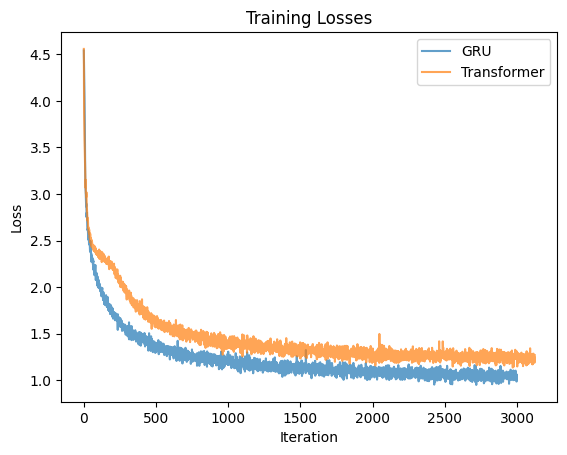

In [50]:
# Now let's see how the Transformer performs on our dataset.

seq_length = 100
batch_size = 32
lr = 1e-3

dataset = CharLMDataset(full_text, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

transformer_model = Transformer(TransformerConfig()).to(DEVICE)

print(f"Parameters: {sum(p.numel() for p in transformer_model.parameters())}")

transformer_losses = train_language_model(transformer_model, dataloader, lr=lr, max_iters=15_000, is_rnn=False)

print(len(transformer_losses), len(gru_losses), len(simple_rnn_losses))

# Generate sample text from Transformer
sample_text = transformer_model.generate_text(dataset)
print(f"\nSample text from Transformer: {sample_text}")
print("-" * 80)

# Plot the loss curves of all three models
plot_losses({
    "GRU": gru_losses,
    "Transformer": transformer_losses,
})

Step 100, Loss: 2.2098, Time: 17.06s
Step 200, Loss: 1.8952, Time: 15.85s
Step 300, Loss: 1.7351, Time: 15.79s
Step 400, Loss: 1.5537, Time: 16.18s
Step 500, Loss: 1.4921, Time: 16.62s
Step 600, Loss: 1.4354, Time: 15.78s
Step 700, Loss: 1.3986, Time: 16.10s
Step 800, Loss: 1.3235, Time: 16.72s
Step 900, Loss: 1.4031, Time: 15.69s
Step 1000, Loss: 1.3220, Time: 15.81s
Step 1100, Loss: 1.3207, Time: 16.43s
Step 1200, Loss: 1.2565, Time: 16.36s
Step 1300, Loss: 1.2443, Time: 15.96s
Step 1400, Loss: 1.3080, Time: 15.67s
Step 1500, Loss: 1.2067, Time: 16.94s
Step 1600, Loss: 1.2126, Time: 16.48s
Step 1700, Loss: 1.2040, Time: 15.91s
Step 1800, Loss: 1.1789, Time: 17.12s
Step 1900, Loss: 1.1627, Time: 15.94s
Step 2000, Loss: 1.1674, Time: 15.90s
Step 2100, Loss: 1.1584, Time: 16.84s
Step 2200, Loss: 1.1039, Time: 16.10s
Step 2300, Loss: 1.1401, Time: 16.04s
Step 2400, Loss: 1.1939, Time: 16.49s
Step 2500, Loss: 1.1639, Time: 16.25s
Step 2600, Loss: 1.1072, Time: 16.13s
Step 2700, Loss: 1.12

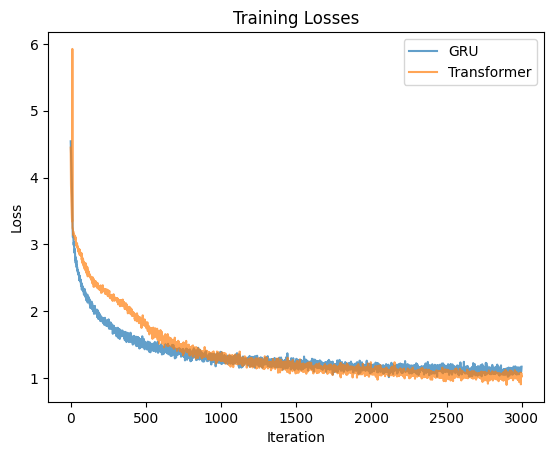

In [51]:
# Very little improvement! In a course on Deep Learning, though, it might make sense to try some more layers. Here,
# we compare the GRU and Transformer, roughly parameter-matched, at 8 layers each.

max_iters = 3_000

gru_model = GRULM(
    vocab_size=len(dataset.vocab),
    embed_size=32,
    hidden_size=192,
).to(DEVICE)
gru_losses = train_language_model(gru_model, dataloader, lr=lr, max_iters=max_iters)
print(f"GRU parameters: {sum(p.numel() for p in gru_model.parameters()):.1e}")

sample_text = gru_model.generate_text(dataset)
print(f"\nSample text from GRU: {sample_text}")
print("-" * 80)


cfg = TransformerConfig(
    vocab_size=len(dataset.vocab),
    n_embd=128,  # Here, we're choosing an embedding size to roughly match the GRUs parameters
    block_size=seq_length,
    n_layer=8,
    n_head=4,
    flash=True,
)

transformer_model = Transformer(cfg).to(DEVICE)
print(f"Transformer parameters: {sum(p.numel() for p in transformer_model.parameters()):.1e}")

transformer_losses = train_language_model(transformer_model, dataloader, lr=lr, max_iters=max_iters, is_rnn=False)

sample_text = transformer_model.generate_text(dataset)
print(f"\nSample text from Transformer: {sample_text}")
print("-" * 80)

plot_losses({
    "GRU": gru_losses,
    "Transformer": transformer_losses,
})

# There are two things to notice here. First, the GRU really struggles as you add more layers. The Transformer's
# residual connections, layer normalization, and GELU activations help it successfully propagate gradients. Second,
# the Transformer, despite having the same number of parameters, takes much, much less time to train. Flash attention
# (Dao et al., 2022)[https://arxiv.org/abs/2205.14135] is a big part of this, but the Transformer is also just more
# efficient to train generally, especially with large batch sizes and longer sequences. Try disabling the flash
# attention to see how much slower the default implementation is.

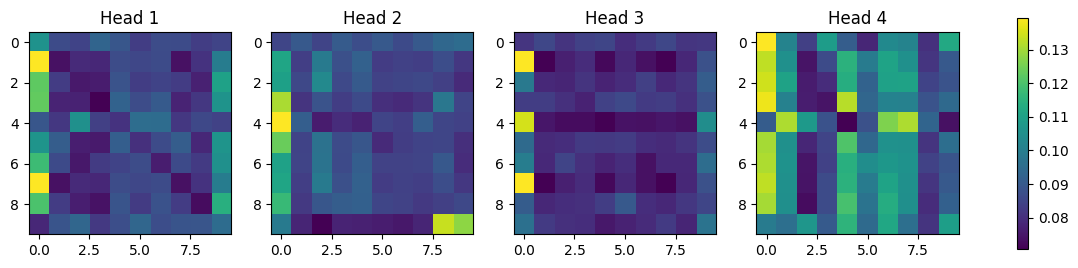

In [52]:
# Transformers are ubiquitous. It would be nice to understand them better. One way people have tried to this is to look
# at their attention patterns. Let's try to do this for our models.


# Add a helper function to visualize attention patterns
def plot_attention_patterns(model, text, dataset):
    """Visualize the attention patterns for a given input text"""
    # Convert text to tokens
    tokens = [dataset.stoi[c] for c in text]
    x = torch.tensor(tokens).unsqueeze(0).to(DEVICE)

    # Get attention weights
    with torch.no_grad():
        B, T = x.size()
        block = model.transformer.blocks[0]
        q, k, v = block.attn.c_attn(block.ln_1(model.transformer.token_embedding(x))).split(model.config.n_embd, dim=2)
        k = k.view(B, T, model.config.n_head, -1).transpose(1, 2)
        q = q.view(B, T, model.config.n_head, -1).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)

    # Plot heatmap for each attention head
    fig, axes = plt.subplots(1, model.config.n_head, figsize=(15, 3))
    for h in range(model.config.n_head):
        im = axes[h].imshow(att[0, h].cpu())
        axes[h].set_title(f"Head {h + 1}")
    plt.colorbar(im, ax=axes)
    plt.show()

plot_attention_patterns(transformer_model, "Lily said,", dataset)

# Experiment with some more input examples. Do you notice anything about how the patterns change? Do particular heads
# behave differently from each other? How?